## Reconhecimento Facial com CNN

Integrantes:

Ana Clara

João Gabriel

João Paulo

Leonardo 

Matheus

### Pip Install e Importação das bibliotecas

In [1]:
pip install facenet-pytorch ultralytics opencv-python matplotlib scikit-learn

In [2]:
import os
import cv2
import torch
import pickle
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from datetime import datetime
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from ultralytics import YOLO

### Configuração

In [101]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #define se o código será executado na GPU ou CPU
THRESHOLD = 0.50 #Se a distância for menor que o THRESHOLD, considera-se que é a mesma pessoa
DB_PATH = 'embeddings.pkl' #onde ficam salvos os embeddings faciais e os rótulos
IMG_DIR = 'imagens_usuarios' #onde ficam armazenadas as imagens dos usuários cadastrados.

### Inicialização dos modelos

In [102]:
model_yolo = YOLO('yolov8n.pt') #detecção de rostos em imagens
model_embed = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE) #Carrega o modelo InceptionResnetV1, treinado com o dataset VGGFace2, para gerar embeddings faciais
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

### Frame

In [103]:
def mostrar_frame_inline(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #  converte a imagem de BGR para RGB
    plt.figure(figsize=(6, 4))
    plt.imshow(frame_rgb)
    plt.axis('off') #Remove os eixos da imagem
    clear_output(wait=True)
    plt.show()

In [104]:
def detectar_rosto(frame):
   result = model_yolo.predict(source=frame, conf=0.7, max_det=1, verbose=False) #detectar objetos no frame.
   boxes = result[0].boxes.xyxy.cpu().numpy() if result[0].boxes else []
   if len(boxes):
    x1, y1, x2, y2 = boxes[0].astype(int)
    face = frame[y1:y2, x1:x2]
    return face
   return None


### Embedding

In [105]:
def gerar_embedding(face):
    img = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB)) # Converte o frame OpenCV (BGR) para PIL Image (RGB)
    tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = model_embed(tensor)
    return emb.squeeze().cpu().numpy()

### Banco

In [106]:
def carregar_banco():
    if os.path.exists(DB_PATH):
        with open(DB_PATH, 'rb') as f:
            return pickle.load(f)
    return {'embeddings': [], 'nomes': []}

def salvar_banco(banco):
    with open(DB_PATH, 'wb') as f:
        pickle.dump(banco, f)

### Cadastro

In [121]:
def cadastrar_usuario(frame, face):
    nome = input("[Cadastro] Nome do novo usuário: ").strip()
    if not nome:
        print("[Aviso] Nome inválido. Cadastro cancelado.")
        return

    if not os.path.exists(IMG_DIR):
        os.makedirs(IMG_DIR)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    img_path = os.path.join(IMG_DIR, f"{nome}_{timestamp}.jpg")
    cv2.imwrite(img_path, face)
    print(f"[Cadastro] Imagem salva em {img_path}")

    emb = gerar_embedding(face)

    banco = carregar_banco()
    print(f"[DEBUG] Nome: {nome}")
    print(f"[DEBUG] Embedding shape: {emb.shape}")
    print(f"[DEBUG] Valores iniciais: {emb[:5]}")
    banco['embeddings'].append(emb)
    banco['nomes'].append(nome)
    salvar_banco(banco)
    print(f"[Cadastro] {nome} adicionado ao banco de dados.")



### Reconhecer

In [122]:
import time

def reconhecer_jupyter(tempo=15):
    banco = carregar_banco()
    cap = cv2.VideoCapture(0)
    print(f"[INFO] Rodando por {tempo} segundos...")

    t0 = time.time()
    rosto_desconhecido = None
    ultimo_nome = ""

    while time.time() - t0 < tempo:
        ret, frame = cap.read()
        if not ret:
            break

        face = detectar_rosto(frame)
        nome = "Nenhum rosto"

        if face is not None:
            try:
                emb = gerar_embedding(face).reshape(1, -1)
                if banco['embeddings']:
                    sims = cosine_similarity(emb, np.array(banco['embeddings']))[0]
                    max_sim = np.max(sims)
                    idx = np.argmax(sims)
                    nome = banco['nomes'][idx] if max_sim > (1 - THRESHOLD) else "Desconhecido"
                else:
                    nome = "Desconhecido"

                if nome == "Desconhecido":
                    rosto_desconhecido = face
                    cv2.putText(frame, "Desconhecido - Será cadastrado ao final", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                else:
                    ultimo_nome = nome
                    cv2.putText(frame, f"{nome}", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            except Exception as e:
                print("[Erro]", e)

        mostrar_frame_inline(frame)

    cap.release()
    print("[INFO] Captura encerrada.")

    if rosto_desconhecido is not None:
        resposta = input("Deseja cadastrar o rosto desconhecido? (s/n): ").strip().lower()
        if resposta == 's':
            cadastrar_usuario(frame, rosto_desconhecido)

    cap.release()

    print("[INFO] Captura encerrada.")

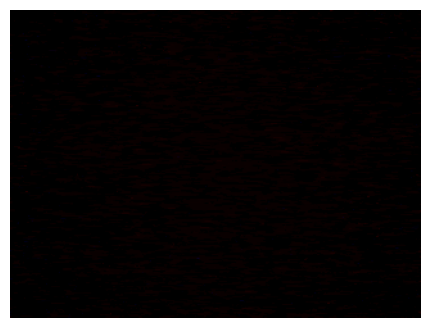

[INFO] Captura encerrada.
[INFO] Captura encerrada.


In [127]:
reconhecer_jupyter(tempo=15)

### Análise

In [128]:
def analisar_embeddings():
    banco = carregar_banco()
    X = np.array(banco['embeddings'])
    y = np.array(banco['nomes'])

    if len(set(y)) < 2:
        print("[Análise] É necessário mais de uma classe para análise.")
        return

    # Leave-one-out validação
    y_pred = []
    for i in range(len(X)):
        query = X[i].reshape(1, -1)
        base_X = np.delete(X, i, axis=0)
        base_y = np.delete(y, i)
        sims = cosine_similarity(query, base_X)[0]
        nome_pred = base_y[np.argmax(sims)]
        y_pred.append(nome_pred)

    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred, labels=np.unique(y))

    print(f"Acurácia (Leave-One-Out): {acc:.2f}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # PCA ou t-SNE para visualização 2D
    reducer = PCA(n_components=2)
    X_2d = reducer.fit_transform(X)
    plt.figure(figsize=(8, 6))
    for nome in np.unique(y):
        idx = y == nome
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=nome)
    plt.title("Visualização dos Embeddings (PCA)")
    plt.legend()
    plt.show()

Acurácia (Leave-One-Out): 0.99


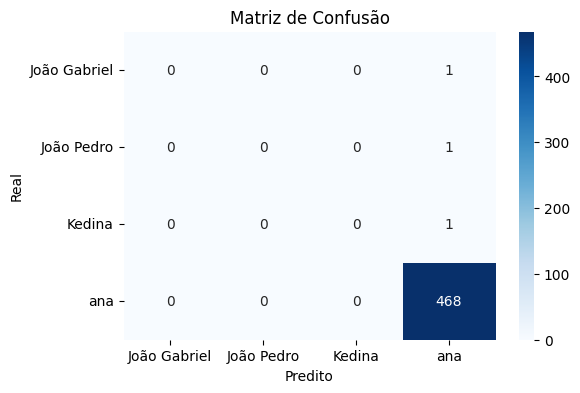

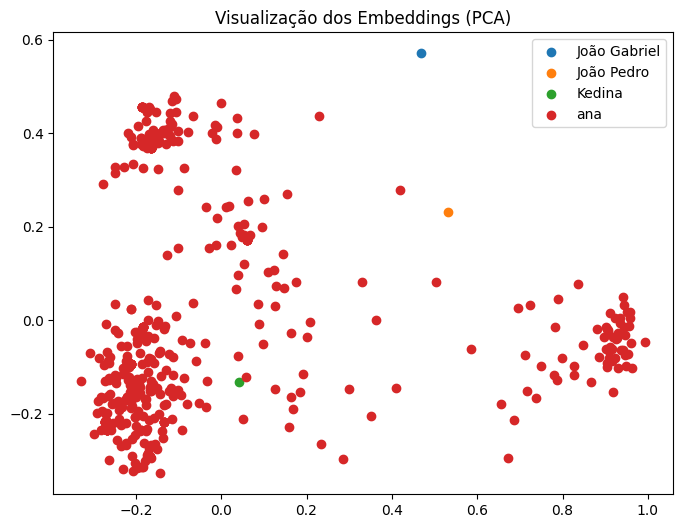

In [129]:
analisar_embeddings()